# Exercício: LoRA

Elton Cardoso do Nascimento, 233840.

Enunciado (`→` descreve as implementações realizadas):

> - Exercício didático para entender a técnica de fazer ajuste fino em modelos grandes usando poucos recursos
> - Aplicar no pré exercício de análise de sentimento ou no segundo exercício, e modelo de linguagem, com vocabulário de 3000 palavras, embedding size e 2 camadas, treinados da forma usual (medir tempo de treinamento/época) `→LoRA aplicado no segundo exercício, porém com 3 camadas lineares (modelo completo)`
> - Modificar o seu modelo para adotar a técnica do LoRA no embedding e nas 2 camadas, e fazer o ajuste-fino, isto é, continuar o treinamento anterior, lembrando que as matrizes originais ficarão congeladas e o ajuste dos pesos serão apenas aplicados nas matrizes do LoRA. Medir o tempo de treinamento/época. `→ LoRA aplicado nas camadas lineares e de Embedding, LoRA_Module.__init__ desabilita os gradientes do modelo original, é comparado o tempo de treino original e com LoRA`
> - Por último, substituir o modelo original, com os novos pesos calculados pelo W + LoRA. `→ LoRA_Module.reduce_module gera a versão com pesos atualizados`
> 
> O que é esperado de aprendizado com LoRA:
> 
> - [x] Modificar o modelo para incluir a soma das duas matrizes do LoRA `→ Cada LoRA_Module implementa o mecanismo específico de cada camada, sendo implementado para camadas lineares e Embedding`
> - [x] Congelar parte do modelo para poder avançar no treino com a mesma tarefa, porém utilizando apenas as matrizes do LoRA, com bem menos pesos e consequentemente mais rápido `→ LoRA_Module.__init__ desabilita os gradientes do modelo original`
> - [x] Atualizar o modelo original com o resultado do treino continuado pelo LoRA `→ LoRA_Module.reduce_module gera a versão com pesos atualizados`
> 
> O enunciado é flexível e os objetivos estão acima. A implementação pode ser feita na mesma classe, com um parâmetro que indica se vai usar ou não as matrizes LoRA.

(OBS: as primeiras seções contem códigos retirados dos exercícios anteriores. As novas implementações começam a partir da seção "Implementação do LoRA").

Iremos começar importando os módulos que serão utilizados na atividade:

In [1]:
import string # Manipular strings
from collections import Counter # Fazer contagem de elementos
import random # Operações randômicas
import os # Manipular arquivos
import time # Medição de tempo
import abc # Classes abstratas
import itertools # Iterators
from typing import List, Dict, Union, Tuple, Optional # Type hints

import numpy as np # Operações vetoriais
from numpy.testing import assert_raises, assert_array_equal, assert_array_almost_equal # Testes
from numpy.typing import ArrayLike # Type hints
import tqdm # Print do progresso
import torch # ML
from torch.utils.data import Dataset, DataLoader # Preparação de dados
import matplotlib.pyplot as plt # Plots
import wandb # Logging

E algumas funções auxiliares que serão utilizadas:

In [2]:
def assert_array_not_equal(array1:ArrayLike, array2:ArrayLike) -> None:
    """
    Raises an AssertionError if two array_like objects are equal.

    Args:
        array1 (ArrayLike): First array to check.
        array2 (ArrayLike): Second array to check.
    """
    assert_raises(AssertionError, assert_array_equal, array1, array2)

In [3]:
def reset_seeds(seed:int=18) -> None:
    """
    Resets the random generators from random and torch to a fixed seed.
    """
    random.seed(seed)
    torch.manual_seed(seed)

## Preparação dos dados.

Nesta seção serão definidas funções para preparar os dados para treino do modelo. Devido a necessidade de alterar os parâmetros constantemente durante os experimentos de treino, são definidas em funções as operações que são necessárias. Exemplos são executados para mostrar o funcionamento correto das operações.

### Faz download e carrega o dataset

Nesta seção os dados serão transferidos, lidos e limpos.

O primeiro passo é realizar o download dos dados:

In [4]:
if not os.path.isfile("67724.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67724.txt.utf-8

if not os.path.isfile("67725.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67725.txt.utf-8

Seguido pela leitura:

In [5]:
text = open("67724.txt.utf-8","r", encoding="utf8").read()
text += open("67725.txt.utf-8","r", encoding="utf8").read()

paragraphs = text.split("\n\n")
len(paragraphs)

4971

E limpeza dos dados.

São realizadas as seguintes operações seguindo o paper "A Neural Probabilistic Language Model" (Bengio, 2003).


- Pontuação: é mantida, porém separada do texto para permitir criação de símbolos próprios no vocabulário, e evitar a criação de várias símbolos representando as palavras com pontuação ("pontuação" -> "pontuação" + "," )
- Número: convertidos para símbolo especial. No caso todos os números são convertidos para "999", para que convirjam para o mesmo símbolo no vocabulário
- Letras maiúsculas: convertidas para minúsculas.
- Nomes próprios: não são alterados devido a necessidade de serem identificados, diferente do paper.
- Palavras raras: são removidas ao criar o vocabulário.

In [6]:
def clean_text(text:str) -> str:
    '''
    Clean the text, changing upper case and setting numbers to 999.
    '''
    
    text = text.lower() # Upper Case -> lower case
    
    old_text = text.split()
    new_text = []

    for j in range(len(old_text)):
        word = old_text[j] 

        if word.isdigit(): #Number -> 999
            word = "999"
        elif len(word) > 1 and word[0] in string.punctuation: # Ponctuation -> separate
            old_text.insert(j+1, word[1:])
            word = word[0]
        elif word[-1] in string.punctuation and len(word) > 1: # Ponctuation -> separate
            old_text.insert(j+1, word[:-1])
            old_text.insert(j+2, word[-1])
            
            word = ""
        
        if len(word) > 0: # No empty words
            new_text.append(word)
    
    return " ".join(new_text)

In [7]:
cleaned_paragraphs = [paragraph.replace("\n", " ") for paragraph in paragraphs if paragraph.strip()] # Removes \n

for i in range(len(cleaned_paragraphs)):
    cleaned_paragraphs[i] = clean_text(cleaned_paragraphs[i])


Podemos ver um exemplo de parágrafo limpo do dataset, junto com a quantidade total de parágrafos obtidos:

In [8]:
print("SAMPLE ----------------")
print(cleaned_paragraphs[0])
print("---------------------")

print(len(cleaned_paragraphs))

SAMPLE ----------------
﻿the project gutenberg ebook of o guarany : romance brazileiro , vol . 999 ( of 999 ) this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it , give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org . if you are not located in the united states , you
---------------------
4892


### Análise do dataset

In [9]:
def count_words(texts:List[str]) -> Counter:
    """
    Counts the words in the texts.

    Args:
        texts (List[str]): List of strings with the texts.

    Returns:
        Counter: counter with the word count across all texts.
    """
    
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split(" "))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

len(word_counts)

11470

### Criando um vocabulário

Com a contagem de palavras podemos definir uma função para criar um novo vocabulário:

In [10]:
def create_vocab(word_counts:Counter, vocab_size:int) -> Tuple[Dict[str, int], List[str]]:
    """
    Generates the vocabulary with the most frequent words.

    Args:
        word_counts (Counter): word count to generate vocabulary.
        vocab_size (int): maximum size for the vocabulary.

    Returns:
        Dict[str, int]: vocabulary mapping words to codes.
        List[str]: inverse vocabulary mapping codes to words.
    """


    most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
    vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}

    inverse_vocab = list(vocab.keys())

    return vocab, inverse_vocab

E podemos executar um teste mostrando a geração de um vocabulário e suas primeiras 0 entradas:

In [11]:
test_vocab_size = 1000
test_vocab, test_inverse_vocab = create_vocab(word_counts, test_vocab_size)

In [12]:
list(itertools.islice(test_vocab.items(), 10))

[(',', 1),
 ('a', 2),
 ('que', 3),
 ('-', 4),
 ('o', 5),
 ('de', 6),
 ('e', 7),
 (';', 8),
 ('.', 9),
 ('um', 10)]

É interessante observar que as palavras mais frequentes são acentuações, o que pode dificultar o aprendizado de sentenças significativas.

### Codificando e Decodificando sentenças

Podemos utilizar as seguintes funções para codificar um texto e decodificá-lo:

In [13]:
def encode_sentence(sentence:Union[str,List[str]], vocab:Dict) -> List[int]:
    """
    Encodes a sentence using a vocabulary.

    Args:
        sentence (Union[str,List[str]]): sentence to encode. Or a string,
            or the string already separated into words
        vocab (Dict): vocabulary to encode. Maps words to codes.

    Returns:
        List[int]: the encoded sentence
    """
    if isinstance(sentence, list):
        words = sentence
    else:
        words = sentence.split(" ")
    
    return [vocab.get(word, 0) for word in words]

In [14]:
def decode_sentence(encoding:List[int], inverse_vocab:List[str]) -> List[str]:
    """
    Decodes a sentence back to words.

    Args:
        encoding (List[int]): encoded sentence to decode.
        inverse_vocab (List[str]): inverse vocabulary. Maps codes to words

    Returns:
        List[str]: decoded sentence. Unknown codes are decoded to '???' 
    """
    result = []

    for encoding_i in encoding:
        if encoding_i == 0:
            result.append("???")
        else:
            result.append(inverse_vocab[encoding_i-1])

    return result

### Separação e Classe do dataset

Aqui iremos definir as sentenças a partir dos textos; divídi-las em treino, teste e valiadação; e criar a classe para carregar os dados durante os experimentos.

In [15]:
def create_sequences(texts:List[str], context_size:int, 
                     vocab:Dict) -> Tuple[List[List[int]], List[int]]:
    """
    Creates sequences from the texts, with the target (word to predict), 
    using a fixed size and vocabulary.

    Args:
        texts (List[str]): texts to create sequences.
        context_size (int): size of the sequences.
        vocab (Dict): maps words to codes.

    Returns:
        List[List[int]]: created sequences. 
        List[int]]: created targets.
    """


    x_all = []
    y_all = []

    for paragraph in texts:
        start = 0
        end = context_size

        paragraph = encode_sentence(paragraph, vocab)

        while end < len(paragraph):
            x = paragraph[start:end]
            y = paragraph[end]

            if not ( 0 in x or 0 == y):
                x_all.append(x)
                y_all.append(y)

            start += 1
            end += 1
            
    x_all = np.array(x_all)
    y_all = np.array(y_all)

    return x_all, y_all

Criamos um dataset de teste e validamos que as entradas e targets possuem o mesmo tamanho.

In [16]:
test_context_size = 10

test_x_all, test_y_all = create_sequences(cleaned_paragraphs, test_context_size, test_vocab)

In [17]:
assert len(test_x_all) == len(test_y_all)

Para evitar viéses, definimos uma função para embaralhar o dataset:

In [18]:
def shuffle_dataset(x:List, y:List) -> Tuple[List, List]:
    """
    Shuffle the dataset.

    Args:
        x (List): dataset inputs.
        y (List): dataset targets.

    Returns:
        List: shuffled inputs. 
        List: shuffled outputs.
    """

    indexes = list(range(len(x)))
    random.shuffle(indexes)

    x = x[indexes]
    y = y[indexes]

    return x, y

E separamos os dados em treino (60%), validação (20%) e teste (20%):

In [19]:
def separate_dataset(x_all:List, y_all:List) -> Tuple[Tuple[List, List], Tuple[List, List], Tuple[List, List]]:
    """
    Separate the data in train, validation and test.

    Args:
        x_all (List): all dataset inputs.
        y_all (List): all dataset targets.

    Returns:
        Tuple[List, List]: train inputs and targets. 
        Tuple[List, List]: validation inputs and targets.
        Tuple[List, List]: test inputs and targets.
    """
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]
    y_train = y_all[0:cut1]

    x_val = x_all[cut1:cut2]
    y_val = y_all[cut1:cut2]

    x_test = x_all[cut2:]
    y_test = y_all[cut2:]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

Separamos os conjuntos e demonstramos que a separação separa corretamente os dados:

In [20]:
(test_x_train, test_y_train), (test_x_val, test_y_val), (test_x_test, test_y_test) = separate_dataset(test_x_all, test_y_all)

In [21]:
assert len(test_x_train)+len(test_x_val)+len(test_x_test) == len(test_x_all)

assert len(test_x_train) == int(0.6*len(test_x_all))
assert len(test_x_val) == np.floor(0.2*len(test_x_all))
assert len(test_x_test) == np.ceil(0.2*len(test_x_all))

assert len(test_x_train) == len(test_y_train)
assert len(test_x_val) == len(test_y_val)
assert len(test_x_test) == len(test_y_test)

Criamos a classe para manipular o dataset:

In [22]:
class TextPredictDataset(Dataset):
    """
    Text prediction dataset.

    Input: sequence of encoded words.
    Target: next word for the sequence.
    """
    
    def __init__(self, x_data:List[List[int]], y_data:List[int]) -> None:
        """
        Creates a new dataset.

        Args:
            x_data (List[List[int]]): dataset inputs.
            y_data (List[int]): dataset targets.

        Raises:
            ValueError: if input and target have different sizes.
        """

        self._x_data = torch.tensor(x_data)-1
        self._y_data = torch.tensor(y_data, dtype=torch.int64)-1
        
        if len(x_data) != len(y_data):
            raise ValueError(f"x_data and y_data must have same size. ({len(x_data)} ≠ {len(y_data)})")
        
        self._size = len(x_data)

    def __len__(self) -> int:
        """
        Gets the size of the dataset.

        Returns:
            int: dataset size.
        """

        return self._size

    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Gets a item of the dataset.

        Args:
            idx (int): data index.

        Returns:
            torch.Tensor: dataset input. 
            torch.Tensor: dataset target.
        """
        return self._x_data[idx], self._y_data[idx]


Geramos um dataset de exemplo e mostramos que os tamanhos das entradas e saídas está correto:

In [23]:
test_train_dataset = TextPredictDataset(test_x_train, test_y_train)

assert_array_equal(test_train_dataset[0][0].shape, [test_context_size])
assert_array_equal(test_train_dataset[0][1].shape, [])

Por fim, mostramos o uso de um DataLoader e mostramos que os dados possuem tamanhos corretos:

In [24]:
test_batch_size = 5
test_train_loader = DataLoader(test_train_dataset, batch_size=test_batch_size, shuffle=True)

test_data = next(iter(test_train_loader))

assert_array_equal(test_data[0].shape, [test_batch_size, test_context_size])
assert_array_equal(test_data[1].shape, [test_batch_size])

### Juntando tudo

Para o uso posterior, podemos juntar todas as funções criadas realizando o processo completo de geração do dataset:

In [25]:
def create_data_loaders(texts:List[str], vocab_size:int, context_size:int, batch_size:int) -> Tuple[Dict, List, Dict[str, DataLoader]]:
    """
    Generates a text prediction dataset.

    Args:
        texts (List[str]): texts to generate the dataset.
        vocab_size (int): size of the vocabulary (know words).
        context_size (int): size of the sequences.
        batch_size (int): size of the batchs.

    Returns:
        Dict: vocabulary. Maps words to codes.
        List: inverse vocabulary. Maps codes to words.
        Dict[str, DataLoader]: dataloaders.
    """

    word_counts = count_words(texts)
    vocab, inverse_vocab = create_vocab(word_counts, vocab_size)

    x_all, y_all = create_sequences(texts, context_size, vocab)
    
    x_all, y_all = shuffle_dataset(x_all, y_all)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = separate_dataset(x_all, y_all)

    train_dataset = TextPredictDataset(x_train, y_train)
    val_dataset = TextPredictDataset(x_val, y_val)
    test_dataset = TextPredictDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    dataloaders = {"train": train_loader, "val":val_loader, "test":test_loader}

    return vocab, inverse_vocab, dataloaders

## Modelo

Esta seção irá implementar o base modelo que será treinado, baseado em "A Neural Probabilistic Language Model" (Bengio, 2003).

### Embedding

Para o embedding utilizamos uma matriz de look-up aprendível:

In [26]:
class Embedding(torch.nn.Module):
    """
    Converts codes to embeddings.
    """

    def __init__(self, embed_dim:int, vocab_size:int) -> None:
        """
        Creates a new Embedding layer.

        Args:
            embed_dim (int): size of the embedding in the output.
            vocab_size (int): size of the vocabulary the words were coded.
        """

        super().__init__()

        self._embed_dim = embed_dim
        self._vocab_size = vocab_size

        C = torch.Tensor(vocab_size, embed_dim)
        torch.nn.init.xavier_uniform_(C)
        self.C = torch.nn.Parameter(C)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        """
        Embeds the input sequences.

        Args:
            input_tensor (torch.Tensor): sequences to be embeded.

        Returns:
            torch.Tensor: result embeddings.
        """
        
        result = torch.index_select(self.C, 0, input_tensor.flatten())
        result = result.reshape(-1, input_tensor.shape[-1], self._embed_dim)
        
        return result

E testamos se a camada gera o embedding corretamente:

In [27]:
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size

test_data = torch.empty((2, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_vocab_size)

embedding = Embedding(test_embed_dim, test_vocab_size)

result = embedding(test_data)
result = result.detach()

C = embedding.C.detach()

assert_array_equal(C.shape, [test_vocab_size, test_embed_dim]) #C matrix have correct shape
assert_array_equal(result.shape, [2, test_sequence_size, test_embed_dim])
assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_equal(result[0, 0], C[0]) #First result = embedding of first word

### Modelo

In [28]:

class LanguageModel(torch.nn.Module):

    def __init__(self, context_size:int, vocab_size:int, embed_dim:int, hidden_units:int):
        super().__init__()
        
        #V = |Vocab|, m = |Embed|
        #n-1 = c = |Context|
        #h = |Hidden|
        
        #C[V, m](input) -> x[c*m]
        #Linear1(x) -> x2[h]
        #ReLU(x2) -> x3[h]  | alterado do paper (tanh)
        #Linear2(x) -> x4[V]
        #Linear3(x3) -> x5[V] | sem bias (Linear2 já tem bias)
        #Add(x4, x5) -> output
        #Sem softmax -> melhor estabilidade

        m = int(context_size*embed_dim)

        self.embedding = Embedding(embed_dim, vocab_size)
        self.linear1 = torch.nn.Linear(m, hidden_units)
        self.relu = torch.nn.ReLU() 
        self.linear2 = torch.nn.Linear(m, vocab_size)
        self.linear3 = torch.nn.Linear(hidden_units, vocab_size, bias=False)

    def forward(self, x:torch.Tensor) -> torch.Tensor:

        x = self.embedding(x)
        x = x.flatten(start_dim=1)
        
        x2 = self.linear1(x)
        x3 = self.relu(x2)
        x4 = self.linear2(x)
        x5 = self.linear3(x3)

        output = x4+x5

        return output

#### Teste do Modelo

Testamos o modelo com uma entrada aleatória para verificar se as saídas possuem tamanhos corretos:

In [29]:
test_batch_size = 5
test_embed_dim = 2
test_vocab_size = 3
test_hidden_units = 3
test_sequence_size = test_vocab_size

test_model = LanguageModel(test_sequence_size, test_vocab_size, test_embed_dim, test_hidden_units)

In [30]:
test_data = torch.empty((test_batch_size, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_sequence_size)

inputs = test_data
targets = test_vocab_size*torch.rand(test_batch_size).long()

output = test_model(inputs)
result = output.argmax(dim=1)

assert_array_equal(output.shape, [test_batch_size, test_vocab_size])
assert_array_equal(result.shape, targets.shape)

## Pré-treino

Nesta seção iremos realizar o treino inicial, iniciando pela definição de algumas funções auxiliares.

### Funções auxiliares

Iremos definir quatro funções auxiliares para: calcular a perplexidade a partir da loss, printar informações, calcular a loss e realizar o treinamento:

In [31]:
def ppl(loss:torch.Tensor) -> torch.Tensor:
    """
    Computes the perplexity from the loss.

    Args:
        loss (torch.Tensor): loss to compute the perplexity.

    Returns:
        torch.Tensor: corresponding perplexity.
    """
    return torch.exp(loss)

In [32]:
def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, 
               time:float=0.0, accuracy:Optional[float]=None):
    """
    Prints the information of a epoch.

    Args:
        loss_value (torch.Tensor): epoch loss.
        epoch (int): epoch number.
        total_epochs (int): total number of epochs. 
        time (float, optional): time to run the epoch. Don't print if is 0.0. Defaults to 0.0.
        accuracy (float, optional): epoch accuracy.
    """
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if accuracy is not None:
        print(f', Accuracy: {100*accuracy:.4f}%')

    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")

In [33]:
MODE_TRAIN = 0
MODE_EVALUATE = 1

In [34]:
def compute_loss(model:torch.nn.Module, loader:DataLoader, 
                 criterion:torch.nn.Module, mode:int = MODE_EVALUATE, 
                 optimizer:Optional[torch.optim.Optimizer]=None, 
                 accumulation_steps:Optional[int] = 1) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Computes the loss from a model across a dataset.

    If in train mode also runs optimizer steps.

    Args:
        model (torch.nn.Module): model to evaluate.
        loader (DataLoader): dataset.
        criterion (torch.nn.Module): loss function to compute.
        mode (int): mode of the computation. 
                    If MODE_EVALUATE, computes without gradient, in eval mode and detachs loss.
                    If MODE_TRAIN, computes with gradient and in train mode.
                    Default is MODE_EVALUATE.
        optimizer (torch.optim.Optimizer, optional): optimizer to use in the train mode.

    Returns:
        torch.Tensor: resulting loss.
    """
    device = next(iter(model.parameters())).device

    if mode == MODE_EVALUATE:
        model.eval()
        torch.set_grad_enabled(False)
    elif mode == MODE_TRAIN:
        model.train()
        torch.set_grad_enabled(True)
        optimizer.zero_grad()
    else:
        raise ValueError(f"Unknown mode: {mode}.")

    batch_index = 0
    total_loss = torch.tensor(0, dtype=torch.float32, device=device)
    n = 0
    for inputs, targets in tqdm.tqdm(loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        logits = model(inputs)
        logits = logits.view(-1, logits.shape[-1])

        loss : torch.Tensor = criterion(logits.squeeze(), targets)
        total_loss += loss*targets.size(0)
        
        
        n += targets.size(0)

        if mode == MODE_TRAIN:
            loss /= accumulation_steps
            loss.backward()

            if ((batch_index+1) % accumulation_steps == 0) or (batch_index+1 == len(loader)):
                optimizer.step()
                optimizer.zero_grad()

        batch_index += 1

    total_loss /= n 
    
    torch.set_grad_enabled(True)

    total_loss = total_loss.detach()

    return total_loss


In [35]:
def train(model:torch.nn.Module, criterion:torch.nn.Module, optimizer:torch.optim.Optimizer, 
          dataloaders:DataLoader, n_epoch:int, accumulation_steps:int=1, 
          use_wandb:bool=False) -> Dict[str, ArrayLike]:
    hist = {}
    hist["loss_train"] = []
    hist["loss_val"] = []
    hist["ppl_train"] = []
    hist["ppl_val"] = []
    hist["time"] = []

    loss_val = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
        
    print("VAL ", end="")
    print_info(loss_val, -1, n_epoch)

    for epoch in range(n_epoch):
        start_time = time.time() 

        loss_train = compute_loss(model, dataloaders["train"], criterion, MODE_TRAIN, optimizer, accumulation_steps)

        end_time = time.time() 
        
        epoch_duration = end_time - start_time 

        ppl_train = ppl(loss_train)

        print_info(loss_train, epoch, n_epoch, epoch_duration)
        
        #Validation stats
        loss_val = compute_loss(model, dataloaders["val"], criterion, MODE_EVALUATE)
        ppl_val = ppl(loss_val)
        
        print("VAL ", end="")
        print_info(loss_val, epoch, n_epoch)

        #Save history
        hist["loss_train"].append(loss_train.item())
        hist["loss_val"].append(loss_val.item())
        hist["ppl_train"].append(ppl_train.item())
        hist["ppl_val"].append(ppl_val.item())
        hist["time"].append(epoch_duration)


        log = {
            "loss_train": loss_train.item(),
            "loss_val": loss_val.item(),
            "ppl_train": ppl_train.item(),
            "ppl_val": ppl_val.item(),
        }

        if use_wandb:
            wandb.log(log)

    for key in hist:
        hist[key] = np.array(hist[key])

    if use_wandb:
        wandb.finish()

    return hist

### Inicialização

Começamos o processo de treino inicializando as variáveis.

Definimos se será realizado o logging utilizando o wandb:

In [36]:
use_wandb = False

Checamos se existe uma GPU disponível:

In [37]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Definimos os parâmetros de treino:

Definimos os parâmetros de treino:

In [38]:
accumulation_steps = 1 # Passos de acumulação de gradiente
batch_size = 32 # Tamanho de um batch
context_size = 5 # Tamanho de uma sequência
embed_dim = 64 # Tamanho do feature vector de cada palavra
hidden_units = 300 # Quantidade de unidades na camada escondida
lr = 5e-1 # Taxa de treinamento
n_epoch = 10 # Quantidade de epochs
optimizer_class = torch.optim.SGD # Otimizador
vocab_size = 3000 # Quantidade de palavras no vocabulário
weight_decay = 1e-3 # Regularização L2

config = {
    "accumulation_steps": accumulation_steps,
    "batch_size": batch_size,
    "embed_dim":embed_dim,
    "hidden_units":hidden_units,
    "lr": lr,
    "n_epoch": n_epoch,
    "optimizer_class": optimizer_class.__name__,
    "context_size" : context_size,
    "weight_decay": weight_decay,
}

if use_wandb:
    run = wandb.init(project="IA024-06-LoRA-Base", config=config)

Reiniciamos as sementes:

In [39]:
reset_seeds()

Criamos o vocabulário, dataset, modelo, loss, otimizador e dataloaders:

In [40]:
vocab, inverse_vocab, dataloaders = create_data_loaders(cleaned_paragraphs, vocab_size, context_size, batch_size)


base_model = LanguageModel(context_size, vocab_size, embed_dim, hidden_units)
base_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optimizer_class(base_model.parameters(), lr=lr, weight_decay=weight_decay)

C:\Users\Elton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Treino

In [41]:
basetrain_history = train(base_model, criterion, optimizer, dataloaders, n_epoch, accumulation_steps, use_wandb)

100%|██████████| 239/239 [00:00<00:00, 246.00it/s]


VAL Epoch [0/10],             Loss: 8.0003,             Perplexity: 2981.9731


100%|██████████| 715/715 [00:07<00:00, 93.79it/s] 


Epoch [1/10],             Loss: 6.1736,             Perplexity: 479.8941, Elapsed Time: 7.64 sec


100%|██████████| 239/239 [00:00<00:00, 304.88it/s]


VAL Epoch [1/10],             Loss: 5.7876,             Perplexity: 326.2298


100%|██████████| 715/715 [00:06<00:00, 105.23it/s]


Epoch [2/10],             Loss: 5.6037,             Perplexity: 271.4308, Elapsed Time: 6.81 sec


100%|██████████| 239/239 [00:00<00:00, 296.01it/s]


VAL Epoch [2/10],             Loss: 5.5218,             Perplexity: 250.0778


100%|██████████| 715/715 [00:06<00:00, 107.17it/s]


Epoch [3/10],             Loss: 5.2936,             Perplexity: 199.0536, Elapsed Time: 6.68 sec


100%|██████████| 239/239 [00:00<00:00, 325.48it/s]


VAL Epoch [3/10],             Loss: 5.3614,             Perplexity: 213.0181


100%|██████████| 715/715 [00:06<00:00, 102.98it/s]


Epoch [4/10],             Loss: 5.0722,             Perplexity: 159.5252, Elapsed Time: 6.96 sec


100%|██████████| 239/239 [00:00<00:00, 311.31it/s]


VAL Epoch [4/10],             Loss: 5.2387,             Perplexity: 188.4164


100%|██████████| 715/715 [00:06<00:00, 106.99it/s]


Epoch [5/10],             Loss: 4.9181,             Perplexity: 136.7440, Elapsed Time: 6.69 sec


100%|██████████| 239/239 [00:00<00:00, 307.47it/s]


VAL Epoch [5/10],             Loss: 5.2078,             Perplexity: 182.6973


100%|██████████| 715/715 [00:06<00:00, 107.94it/s]


Epoch [6/10],             Loss: 4.8079,             Perplexity: 122.4687, Elapsed Time: 6.64 sec


100%|██████████| 239/239 [00:00<00:00, 328.93it/s]


VAL Epoch [6/10],             Loss: 5.2073,             Perplexity: 182.5919


100%|██████████| 715/715 [00:06<00:00, 107.53it/s]


Epoch [7/10],             Loss: 4.7229,             Perplexity: 112.4965, Elapsed Time: 6.66 sec


100%|██████████| 239/239 [00:00<00:00, 315.32it/s]


VAL Epoch [7/10],             Loss: 5.1154,             Perplexity: 166.5742


100%|██████████| 715/715 [00:06<00:00, 104.41it/s]


Epoch [8/10],             Loss: 4.6500,             Perplexity: 104.5895, Elapsed Time: 6.86 sec


100%|██████████| 239/239 [00:00<00:00, 283.53it/s]


VAL Epoch [8/10],             Loss: 5.1138,             Perplexity: 166.2961


100%|██████████| 715/715 [00:06<00:00, 110.68it/s]


Epoch [9/10],             Loss: 4.5941,             Perplexity: 98.8986, Elapsed Time: 6.47 sec


100%|██████████| 239/239 [00:00<00:00, 375.74it/s]


VAL Epoch [9/10],             Loss: 5.0766,             Perplexity: 160.2320


100%|██████████| 715/715 [00:05<00:00, 122.65it/s]


Epoch [10/10],             Loss: 4.5418,             Perplexity: 93.8578, Elapsed Time: 5.84 sec


100%|██████████| 239/239 [00:00<00:00, 370.55it/s]

VAL Epoch [10/10],             Loss: 5.0727,             Perplexity: 159.6102


Observamos que o modelo treina corretamente, porém com considerável overfitting:

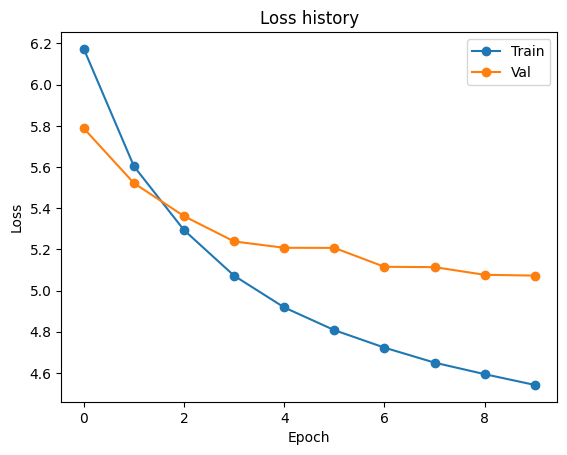

In [42]:
plt.plot(basetrain_history["loss_train"], "o-")
plt.plot(basetrain_history["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

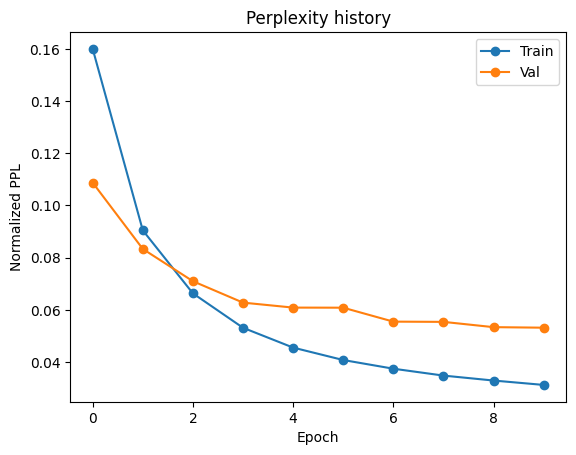

In [43]:
plt.plot(basetrain_history["ppl_train"]/vocab_size, "o-")
plt.plot(basetrain_history["ppl_val"]/vocab_size, "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Normalized PPL")
plt.title("Perplexity history")

plt.show()

## Implementação do LoRA

Uma vez que temos o modelo base pronto, podemos começar a implementação da técnica LoRA.

Para isso, vamos começar implementando uma classe abstrata que representa um módulo LoRA, que recebe o módulo original do modelo, realiza o forward com as matrizes low-rank, e é capaz de obter um módulo reduzido somando os pesos originais com os novos pesos:

In [44]:
class LoRA_Module(torch.nn.Module, abc.ABC):
    '''
    Abstract LoRA module.

    A LoRA module realizes the same kind of operation as the reference module,
    but with low-rank matrices decomposition.
    '''

    def __init__(self, original_module:torch.nn.Module, rank:int, alpha:float) -> None:
        '''
        LoRA_Module constructor.

        Args:
            original_module (torch.nn.Module): original module to be LoRAed
            rank (int): matrices rank. Must be positive and integer.
            alpha (float): scaling parameter for the weight update.

        Raises:
            ValueError: if rank is not positive or integer.
        '''
        super().__init__()

        if rank < 0 or not isinstance(rank, int):
            raise ValueError(f"'rank' must be positive and integer. Received rank={rank}, type={type(rank)}")

        for param in original_module.parameters():
            param.requires_grad = False

        self._original_module = original_module
        self._rank = rank
        self._alpha = alpha
        self._scaling = alpha/rank

    @abc.abstractmethod
    def reduce_module(self) -> torch.nn.Module:
        '''
        Generates a reduced version of the original module,
        incorporating the new calculated weights.

        Returns:
            torch.nn.Module: reduced module.
        '''
        ...

### Linear

O primeiro módulo LoRA que iremos gerar é uma versão do módulo `Linear` utilizando matrizes low-rank, igual descrito no paper:

In [45]:
class LoRA_Linear(LoRA_Module):
    '''
    LoRA version of a Linear module.

    Realizes the operation with low-rank A and B matrices:

    y = x @ Aᵀ @ Bᵀ
    '''
    def __init__(self, linear:torch.nn.Linear, rank:int, alpha:float=1.0) -> None:
        '''
        LoRA_Linear constructor.

        Args:
            linear (torch.nn.Linear): original linear module to be LoRAed.
            rank (int): matrices rank. Must be positive and integer.
            alpha (float): scaling parameter for the weight update. Defaults to 1.0.
        '''

        super().__init__(linear, rank, alpha)
        self._original_module : torch.nn.Linear

        self._in_features = linear.in_features
        self._out_features = linear.out_features

        device = self._original_module.weight.device
        dtype = self._original_module.weight.dtype

        B = torch.empty(self._out_features, rank, device=device, dtype=dtype)
        A = torch.empty(rank, self._in_features, device=device, dtype=dtype)

        torch.nn.init.kaiming_uniform_(A, a=5) # LoRA code initializes this way (??)
        torch.nn.init.zeros_(B)

        self.B = torch.nn.Parameter(B)
        self.A = torch.nn.Parameter(A)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        y1 = self._original_module(x)
        y2 = (x @ self.A.T)@self.B.T * self._scaling

        y = y1+y2
        return y
    
    def reduce_module(self) -> torch.nn.Linear:
        '''
        Reduces to a Linear module,
        incorporating the new calculated weights.

        Returns:
            torch.nn.Linear: reduced linear module.
        '''
        use_bias = self._original_module.bias is not None
        device = self._original_module.weight.device
        dtype = self._original_module.weight.dtype

        linear = torch.nn.Linear(self._in_features, self._out_features, 
                                 use_bias, device, dtype)
        
        W = self._original_module.weight + (self.B@self.A*self._scaling)
        W = torch.nn.Parameter(W)
        linear.weight = W
        linear.bias = self._original_module.bias 
                    
        return linear



E testamos se as operações são realizadas corretamente:

In [46]:
linear = torch.nn.Linear(3,4)
lora_linear = LoRA_Linear(linear, rank=2, alpha=0.5)

In [47]:
x = torch.rand(3)

y_linear = linear(x).detach()
y_lora = lora_linear(x).detach()

assert_array_equal(y_linear, y_lora) #Initialized LoRA have zero weight update

In [48]:
lora_linear.A = torch.nn.Parameter(torch.rand_like(lora_linear.A))
lora_linear.B = torch.nn.Parameter(torch.rand_like(lora_linear.B))

In [49]:
y_lora = lora_linear(x).detach()

assert_array_not_equal(y_linear, y_lora) #LoRA layer changes the output

In [50]:
reduced_linear = lora_linear.reduce_module()

y_reduced = reduced_linear(x).detach()

assert_array_almost_equal(y_reduced, y_lora) #Reduced result is the same as the non-reduced
assert isinstance(reduced_linear, torch.nn.Linear) #Reduced module is of same type as the original

### Embedding

A versão do `Embedding` utilizando LoRA tem uma especificidade de que a primeira operação a ser realizada é um look-up na primeira matriz de pesos, gerando vetores de embeddings no espaço de dimensão menor, para posteriormente ser realizado a multiplicação, obtendo os vetores na dimensão correta:

In [51]:
class LoRA_Embedding(LoRA_Module):
    '''
    LoRA version of a Embedding module.
    '''
    
    def __init__(self, embedding:Embedding, rank:int, alpha:float=1.0) -> None:
        '''
        LoRA_Linear constructor.

        Args:
            embedding (torch.nn.Linear): original embedding module to be LoRAed.
            rank (int): matrices rank. Must be positive and integer.
            alpha (float): scaling parameter for the weight update. Defaults to 1.0.
        '''

        super().__init__(embedding, rank, alpha)
        self._original_module : Embedding

        self._embed_dim = self._original_module._embed_dim
        self._vocab_size = self._original_module._vocab_size

        device = self._original_module.C.device
        dtype = self._original_module.C.dtype

        A = torch.empty(self._vocab_size, rank, device=device, dtype=dtype)
        B = torch.empty(rank, self._embed_dim, device=device, dtype=dtype)
        

        torch.nn.init.normal_(A)
        torch.nn.init.zeros_(B)

        self.A = torch.nn.Parameter(A)
        self.B = torch.nn.Parameter(B)

    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        y1 = self._original_module(x)

        y2 = torch.index_select(self.A, 0, x.flatten())
        y2 = y2.reshape(-1, x.shape[-1], self._rank) # [batch, sequence, rank]

        y2 = y2 @ self.B # [batch, sequence, embed]

        y2 *= self._scaling

        result = y1+y2

        return result

    def reduce_module(self) -> Embedding:
        '''
        Reduces to a Embedding module,
        incorporating the new calculated weights.

        Returns:
            Embedding: reduced embedding module.
        '''

        embedding = Embedding(self._embed_dim, self._vocab_size)

        C = self._original_module.C
        delta_C = self.A@self.B*self._scaling
        C  = C+delta_C

        embedding.C = torch.nn.Parameter(C)

        return embedding


E realizamos mais uma vez testes para validar a implementação:

In [52]:
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size
test_rank = 1

test_data = torch.empty((2, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_vocab_size)



embedding = Embedding(test_embed_dim, test_vocab_size)
lora_embedding = LoRA_Embedding(embedding, test_rank, 0.5)


In [53]:
y_embedding = embedding(test_data).detach()
y_lora = lora_embedding(test_data).detach()

assert_array_equal(y_embedding, y_lora) #Initialized LoRA module have zero weights

In [54]:
lora_embedding.A = torch.nn.Parameter(torch.rand_like(lora_embedding.A))
lora_embedding.B = torch.nn.Parameter(torch.rand_like(lora_embedding.B))

y_lora = lora_embedding(test_data).detach()

assert_array_not_equal(y_embedding, y_lora) #New weights -> different result

In [55]:
reduced_embedding = lora_embedding.reduce_module()

y_reduced = reduced_embedding(test_data).detach()

assert_array_equal(y_reduced, y_lora) #Reduced and non-reduced have same result
assert isinstance(reduced_embedding, Embedding) #Reduced module is Embedding

### Model

E implementamos a classe LoRA_Model, responsável por gerar uma versão LoRA de um modelo inteiro.

O mecanismo para isso é percorrer todos os módulos do modelo original, substituindo eles por versões LoRA; enquanto que a redução irá reduzir todos os módulos LoRAificados (leia-se lorificados):

In [56]:
#Map from original module to LoRA version
LoRA_MAP : Dict[torch.nn.Module, LoRA_Module] = {torch.nn.Linear:LoRA_Linear, Embedding:LoRA_Embedding}

In [57]:
class LoRA_Model(LoRA_Module):
    '''
    Converts a torch module to a LoRA version, with LoRA modules.
    '''

    def __init__(self, original_module: torch.nn.Module, rank: int, alpha: float=1.0) -> None:
        '''
        LoRA_Model constructor.

        Args:
            original_module (torch.nn.Module): module to be LoRAed.
            rank (int): matrices rank. Must be positive and integer.
            alpha (float): scaling parameter for the weight update. Defaults to 1.0.
        '''
        super().__init__(original_module, rank, alpha)

        for name in original_module._modules:
            module = original_module._modules[name]

            for original_class in LoRA_MAP:
                if isinstance(module, original_class):
                    lora_class = LoRA_MAP[original_class]
                    lora_module = lora_class(module, rank, alpha)
                    original_module._modules[name] = lora_module
    
    def reduce_module(self) -> torch.nn.Module:
        '''
        Generates a reduced version of the original module,
        incorporating the new calculated weights.

        Returns:
            torch.nn.Module: reduced module.
        '''
        for name in self._original_module._modules:
            module = self._original_module._modules[name]

            if isinstance(module, LoRA_Module):
                self._original_module._modules[name] = module.reduce_module()

        return self._original_module
    
    def forward(self, *args, **kwargs):
        return self._original_module(*args, **kwargs)

Realizamos um teste inicial para verificar se as operações são realizadas corretamente com o módulo não inicializado:

In [58]:
test_batch_size = 5
test_embed_dim = 2
test_vocab_size = 3
test_hidden_units = 3
test_sequence_size = test_vocab_size

test_rank = 1
test_alpha = 0.5

test_model = LanguageModel(test_sequence_size, test_vocab_size, test_embed_dim, test_hidden_units)
test_lora_model = LoRA_Model(test_model, test_rank, test_alpha)

In [59]:
original_linear1_weight = test_model.linear1._original_module.weight.detach()

In [60]:
test_data = torch.empty((test_batch_size, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_sequence_size)

test_targets = test_vocab_size*torch.rand(test_batch_size).long()

output_original = test_model(test_data).detach()
result_original = output.argmax(dim=1)

output_lora = test_lora_model(test_data).detach()
result_lora = output.argmax(dim=1)


#Correct shapes
assert_array_equal(output_lora.shape, [test_batch_size, test_vocab_size]) 
assert_array_equal(result_lora.shape, test_targets.shape)

#Initialized weights = 0
assert_array_equal(output_lora, output_original)

E realizamos um passo de treino para verificar se o modelo treina corretamente e o mecanismo de redução funciona:

In [61]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(test_lora_model.parameters(), lr=10)

logits = test_lora_model(test_data)
logits = logits.view(-1, logits.shape[-1])

loss : torch.Tensor = criterion(logits.squeeze(), test_targets)

optimizer.zero_grad()
loss.backward()
optimizer.step()

In [62]:
output_lora2 = test_lora_model(test_data).detach()

#Trained result is different
assert_array_not_equal(output_lora, output_lora2)
assert_array_not_equal(output_lora2, output_original)

In [63]:
test_reduced_model = test_lora_model.reduce_module()

output_reduced = test_reduced_model(test_data).detach()

assert_array_almost_equal(output_reduced, output_lora2) #Reduced result is the same as the original
assert isinstance(test_reduced_model, LanguageModel) #Reduced class is correct

#No more LoRA modules
for name in test_reduced_model._modules:
    module = test_reduced_model._modules[name]

    assert not isinstance(module, LoRA_Module)

In [64]:
new_linear1_weight = test_model.linear1.weight.detach()

assert_array_not_equal(new_linear1_weight, original_linear1_weight) #Weights are different from original

## Treino

Com o mecanismo LoRA implementado, podemos LoRAificar o modelo original e realizar mais um treinamento com as matrizes low-rank.

Começamos definindo os parâmetros que serão necessários e reiniciando as sementes para reprodutibilidade:

In [65]:
use_wandb = False

In [66]:
accumulation_steps = 1 # Passos de acumulação de gradiente
batch_size = 32 # Tamanho de um batch
lora_alpha = 32 #LoRA alpha for scaling
lora_rank = 1 #LoRA rank
lr = 5e-3 # Taxa de treinamento
n_epoch = 10 # Quantidade de epochs
optimizer_class = torch.optim.Adam # Otimizador
weight_decay = 1e-3 # Regularização L2

config = {
    "accumulation_steps": accumulation_steps,
    "batch_size": batch_size,
    "lora_alpha" : lora_alpha,
    "lora_rank" : lora_rank,
    "lr": lr,
    "n_epoch": n_epoch,
    "optimizer_class": optimizer_class.__name__,
    "weight_decay": weight_decay,
}

if use_wandb:
    run = wandb.init(project="IA024-06-LoRA-LoRA", config=config)

In [67]:
reset_seeds()

LoRAificamos o modelo e inicializamos os outros objetos:

In [68]:
lora_model = LoRA_Model(base_model, lora_rank, lora_alpha)
lora_model.to(device) #Not necessary, but why not :)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optimizer_class(base_model.parameters(), lr=lr, weight_decay=weight_decay)

E realizamos o novo treino:

In [69]:
loratrain_history = train(lora_model, criterion, optimizer, dataloaders, n_epoch, accumulation_steps, use_wandb)

100%|██████████| 239/239 [00:01<00:00, 234.63it/s]


VAL Epoch [0/10],             Loss: 5.0727,             Perplexity: 159.6105


100%|██████████| 715/715 [00:05<00:00, 119.21it/s]


Epoch [1/10],             Loss: 4.3896,             Perplexity: 80.6073, Elapsed Time: 6.03 sec


100%|██████████| 239/239 [00:00<00:00, 286.71it/s]


VAL Epoch [1/10],             Loss: 5.1115,             Perplexity: 165.9200


100%|██████████| 715/715 [00:05<00:00, 119.37it/s]


Epoch [2/10],             Loss: 4.3008,             Perplexity: 73.7586, Elapsed Time: 6.02 sec


100%|██████████| 239/239 [00:00<00:00, 286.63it/s]


VAL Epoch [2/10],             Loss: 5.1063,             Perplexity: 165.0548


100%|██████████| 715/715 [00:05<00:00, 125.06it/s]


Epoch [3/10],             Loss: 4.2790,             Perplexity: 72.1676, Elapsed Time: 5.75 sec


100%|██████████| 239/239 [00:00<00:00, 286.30it/s]


VAL Epoch [3/10],             Loss: 5.0785,             Perplexity: 160.5279


100%|██████████| 715/715 [00:05<00:00, 122.97it/s]


Epoch [4/10],             Loss: 4.2629,             Perplexity: 71.0124, Elapsed Time: 5.84 sec


100%|██████████| 239/239 [00:00<00:00, 282.81it/s]


VAL Epoch [4/10],             Loss: 5.0983,             Perplexity: 163.7477


100%|██████████| 715/715 [00:05<00:00, 126.74it/s]


Epoch [5/10],             Loss: 4.2549,             Perplexity: 70.4520, Elapsed Time: 5.67 sec


100%|██████████| 239/239 [00:00<00:00, 335.71it/s]


VAL Epoch [5/10],             Loss: 5.0639,             Perplexity: 158.2081


100%|██████████| 715/715 [00:05<00:00, 124.30it/s]


Epoch [6/10],             Loss: 4.2454,             Perplexity: 69.7846, Elapsed Time: 5.79 sec


100%|██████████| 239/239 [00:00<00:00, 281.80it/s]


VAL Epoch [6/10],             Loss: 5.1105,             Perplexity: 165.7610


100%|██████████| 715/715 [00:06<00:00, 104.04it/s]


Epoch [7/10],             Loss: 4.2468,             Perplexity: 69.8797, Elapsed Time: 6.90 sec


100%|██████████| 239/239 [00:00<00:00, 303.48it/s]


VAL Epoch [7/10],             Loss: 5.1184,             Perplexity: 167.0752


100%|██████████| 715/715 [00:05<00:00, 139.91it/s]


Epoch [8/10],             Loss: 4.2468,             Perplexity: 69.8825, Elapsed Time: 5.14 sec


100%|██████████| 239/239 [00:00<00:00, 319.96it/s]


VAL Epoch [8/10],             Loss: 5.0604,             Perplexity: 157.6521


100%|██████████| 715/715 [00:05<00:00, 141.01it/s]


Epoch [9/10],             Loss: 4.2410,             Perplexity: 69.4780, Elapsed Time: 5.10 sec


100%|██████████| 239/239 [00:00<00:00, 321.86it/s]


VAL Epoch [9/10],             Loss: 5.0809,             Perplexity: 160.9174


100%|██████████| 715/715 [00:05<00:00, 135.04it/s]


Epoch [10/10],             Loss: 4.2446,             Perplexity: 69.7282, Elapsed Time: 5.32 sec


100%|██████████| 239/239 [00:00<00:00, 315.11it/s]

VAL Epoch [10/10],             Loss: 5.0344,             Perplexity: 153.5999


Observando a evolução da loss, observamos dois aspectos: primeiramente foi possível treinar as matrizes LoRA, visto o descréscimo da perda de treino; porém, isso não gerou impactos significativos na validação. O segundo aspecto é esperado visto que o conjunto de dados utilizado para realizar este treino é o mesmo do pré-treino, sendo que seria necessário um novo conjunto de dados para validar a eficácia do processo.

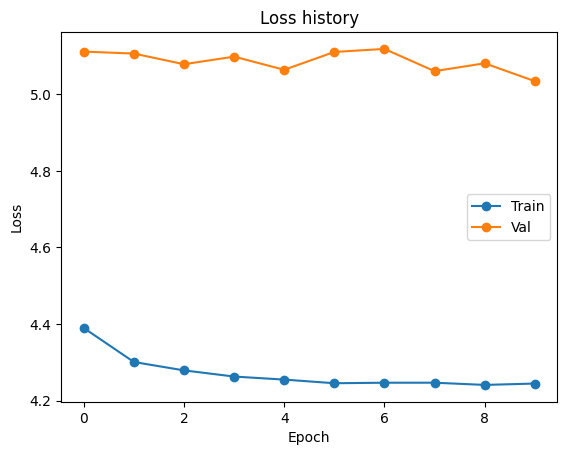

In [70]:
plt.plot(loratrain_history["loss_train"], "o-")
plt.plot(loratrain_history["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

## Comparação

Embora a eficácia do processo não possa ser corretamente avaliada devido ao conjunto de dados, podemos avaliar a performance do processo, observando como que o tempo de treino utilizando LoRA é menor, tanto no total quanto a média de cada época:

In [71]:
funcs = {"Total time":np.sum, "Mean time":np.mean}

for func in funcs:
    print(func, "| Base:", funcs[func](basetrain_history["time"]), "| LoRA:", funcs[func](loratrain_history["time"]))

Total time | Base: 67.25818085670471 | LoRA: 57.548344135284424
Mean time | Base: 6.725818085670471 | LoRA: 5.754834413528442


Para verificar a latência, avaliamos a inferência de um batch com o modelo LoRAificado, reduzido e original:

In [72]:
x, y = next(iter(dataloaders["train"]))
x = x.to(device)

In [73]:
lora_model(x)
%timeit lora_model(x)

2.59 ms ± 190 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
reduced_model = lora_model.reduce_module()

In [75]:
reduced_model(x)
%timeit reduced_model(x)

2.09 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [76]:
test_model = LanguageModel(context_size, vocab_size, embed_dim, hidden_units)
test_model.to(device)
test_model(x)
%timeit test_model(x)

2.37 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


E podemos concluir que a redução remove o tempo extra adicionado pelas operações adicionais dos módulos LoRA:

Versão | Tempo
-|-
LoRA | 2.59 ms ± 190 µs per loop
Reduzido | 2.09 ms ± 87.9 µs
Original | 2.37 ms ± 509 µs

Curiosamente a implementação original teve um tempo concordando com a versão LoRA e reduzida, não apenas com a reduzida como seria esperado. Isso possivelmente é devido a pequena escala em que o LoRA foi aplicado.